# Projeto 2 - Ciência dos Dados
## 2020.2 ~ 2C ~ Estudo do stat "Velocidade" dos Pokémons
### Grupo:
    -Guilherme Rameh
    -Tales Oliveira
    -Gabriella Zullo
    -João Magalhães

In [1]:
import scipy.stats as stats
from scipy.stats import t, norm, probplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, ceil
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

# Para ter melhor print
from IPython.display import display

In [2]:
# Leitura do banco de dados

dados = pd.read_csv('pokemon.csv')
dados

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,NaN,797,107,101,61,steel,flying,999.9,7,1
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,NaN,798,59,31,109,grass,steel,0.1,7,1
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,NaN,799,97,53,43,dark,dragon,888.0,7,1
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,NaN,800,127,89,79,psychic,NaN,230.0,7,1


# Primeira Análise Exploratória
A seguir, verificaremos quais variáveis achamos interessantes de se relacionar com a velocidade dos Pokémons, que é nossa variável *Target*. Começamos printando as colunas do dataframe, pois sabendo do que se trata, podemos descartar algumas colunas logo de cara (como por exemplo as colunas referentes a quanto de dano cada ataque dá em cada tipo de Pokémon).

In [3]:
print(dados.dtypes)

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate          object
classfication         object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

<b> Lembrete: Quando lidando com duas variáveis QUANTITATIVAS, usamos scatter plot, e para variáveis QUALITATÍVAS (como estamos lidando com "speed", que é quantitativo) podemos separar por index e fazer crosstab, ou usar o comando pivot table do pandas, que permite a análise de várias variáveis qualitativas em relação a quantitativas, permitindo até o uso de comandos como média, máx e mín.

### Primeiras modificações no Dataframe

A seguir, manipulamos o dataframe com o intuito de analisar a relação da velocidade com as principais variáveis quantitativas, como ataque, defesa, etc...; Para evitar confusões e dificuldade na leitura dos gráficos, primeiro separamos os tipos de pokémons nos mais frequentes, tanto para o *tipo 1* quanto para o *tipo 2*. Nessa etapa também separamos o dataframe em dois, um de treino e um para testarmos o quão fíel é o nosso modelo.

In [4]:
for i in dados.index:
    type1 = dados.type1[i]
    if type1 == 'water':
        dados.loc[dados.index==i, 'Type1Reorder'] = 'water'
    elif type1 == 'normal':
        dados.loc[dados.index==i, 'Type1Reorder'] = 'normal'
    else:
        dados.loc[dados.index==i, 'Type1Reorder'] = 'other'
        
    type2 = dados.type2[i]
    if type2 == 'flying':
        dados.loc[dados.index==i, 'Type2Reorder'] = 'flying'
    elif type2 == 'ground':
        dados.loc[dados.index==i, 'Type2Reorder'] = 'ground'
    else:
        dados.loc[dados.index==i, 'Type2Reorder'] = 'other'
        
dados.tail(20)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary,Type1Reorder,Type2Reorder
781,"['Bulletproof', 'Soundproof', 'Overcoat']",1.00,1.0,2.0,0.5,2.0,1.00,0.5,1.0,1.0,...,45,45,45,dragon,NaN,29.7,7,0,other,other
782,"['Bulletproof', 'Soundproof', 'Overcoat']",0.50,0.5,2.0,0.5,4.0,1.00,0.5,2.0,1.0,...,65,70,65,dragon,fighting,47.0,7,0,other,other
783,"['Bulletproof', 'Soundproof', 'Overcoat']",0.50,0.5,2.0,0.5,4.0,1.00,0.5,2.0,1.0,...,100,105,85,dragon,fighting,78.2,7,0,other,other
784,"['Electric Surge', 'Telepathy']",0.50,0.5,0.0,0.5,1.0,0.50,1.0,0.5,1.0,...,95,75,130,electric,fairy,20.5,7,1,other,other
785,"['Psychic Surge', 'Telepathy']",1.00,1.0,0.0,1.0,1.0,0.25,1.0,1.0,2.0,...,130,115,95,psychic,fairy,18.6,7,1,other,other
786,"['Grassy Surge', 'Telepathy']",1.00,0.5,0.0,0.5,1.0,0.50,2.0,2.0,1.0,...,85,95,75,grass,fairy,45.5,7,1,other,other
787,"['Misty Surge', 'Telepathy']",0.50,0.5,0.0,2.0,1.0,0.50,0.5,1.0,1.0,...,95,130,85,water,fairy,21.2,7,1,water,other
788,['Unaware'],2.00,2.0,1.0,1.0,1.0,0.50,1.0,1.0,2.0,...,29,31,37,psychic,NaN,0.1,7,1,other,other
789,['Sturdy'],2.00,2.0,1.0,1.0,1.0,0.50,1.0,1.0,2.0,...,29,131,37,psychic,NaN,999.9,7,1,other,other
790,['Full Metal Body'],1.00,2.0,0.5,1.0,0.5,1.00,2.0,0.5,2.0,...,113,89,97,psychic,steel,230.0,7,1,other,other


In [5]:
dummies_type1 = pd.get_dummies(dados['type1'])
dummies_type2 = pd.get_dummies(dados['type2'])

for i in dummies_type1:
    dados.loc[:,'T1_'+i] = dummies_type1[i]
    dados.loc[:,'T2_'+i] = dummies_type2[i]
    
dados

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,T1_poison,T2_poison,T1_psychic,T2_psychic,T1_rock,T2_rock,T1_steel,T2_steel,T1_water,T2_water
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,0,1,0,0,0,0,0,0,0,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,0,1,0,0,0,0,0,0,0,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,0,1,0,0,0,0,0,0,0,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,0,0,0,0,0,0,1,0,0,0
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,0,0,0,0,0,0,0,0,0,0
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,0,0,1,0,0,0,0,0,0,0


In [36]:
lista_train_test = train_test_split(dados, shuffle=True, random_state=1)
train = lista_train_test[0]
test = lista_train_test[1]

# size = 600
# list_of_dfs = [shuffle.iloc[:600,:], shuffle.iloc[600:,:]]
# train = list_of_dfs[0]
# test = list_of_dfs[1]

In [37]:
# Aqui vemos a quantidade de cada tipo, 1 e 2, na base de treino

print(train['type1'].value_counts())
print('\n')
print(train['type2'].value_counts())

water       87
normal      82
grass       60
bug         58
fire        41
psychic     38
rock        36
electric    29
poison      25
dark        23
fighting    21
ground      20
ghost       18
dragon      18
steel       15
ice         14
fairy       14
flying       1
Name: type1, dtype: int64


flying      76
poison      27
fairy       24
psychic     22
ground      20
steel       17
fighting    17
water       15
dark        13
ice         13
grass       13
dragon      12
ghost       10
rock        10
fire         9
electric     7
bug          5
normal       2
Name: type2, dtype: int64


### Análise com o modelo de distribuição "Normal"

Na célula seguinte, usamos o *probplot* e um histograma para analisar a normalidade da variável 'velocidade'. Podemos ver que ela não se distancia tanto da normal, principalmente na cauda esquerda.

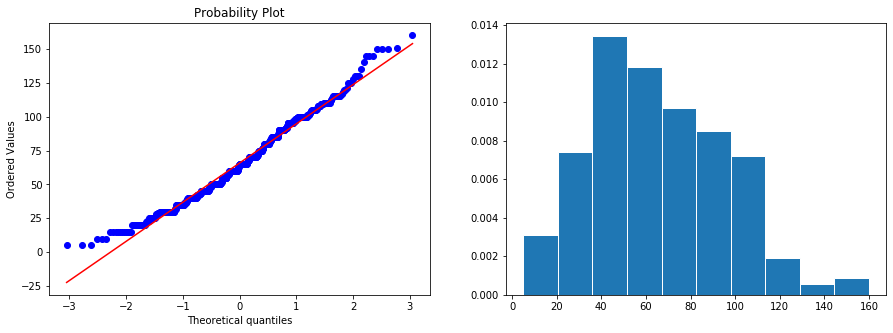

In [38]:
plt.figure(figsize=(15,5))

plt.subplot(121)
probplot(train['speed'], dist='norm', plot=plt)

plt.subplot(122)
plt.hist(train['speed'], density=True, edgecolor='w');

## Plot inicial
Como maneira de visualizar melhor se as variáveis tem relação ao *Target*, plotamos os gráficos *scatterplot* de relação entre as diversas variáveis quantitativas, além de separar por tipos de Pokémon, para ver se com isso conseguíamos visualizar alguma relação, que como se perceberá logo, é bem difícil.

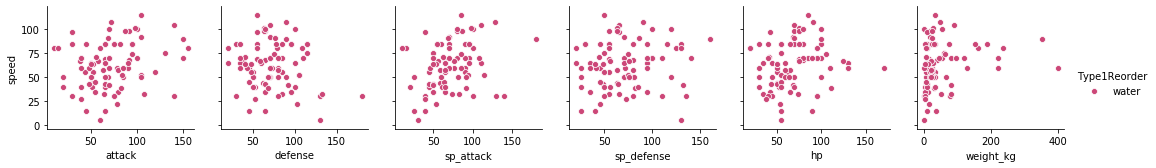

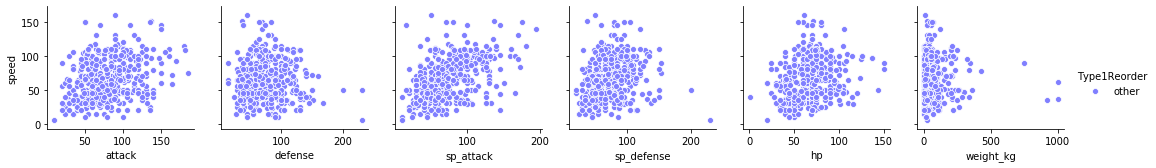

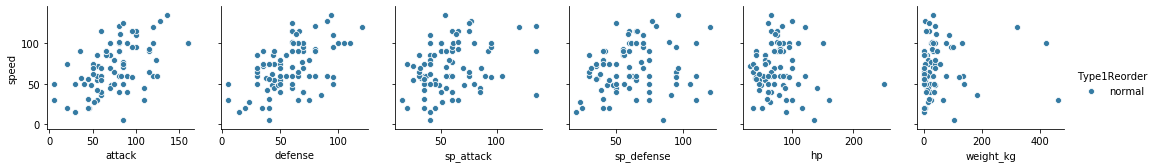

In [39]:
listType1 = train.Type1Reorder.unique()
listType2 = train.Type2Reorder.unique()
colorlist = ['plasma', 'cool', 'mako']

for i in range(3):
    e = listType1[i]
    df = train.loc[train.Type1Reorder==e, :]
    sns.pairplot(df, palette=colorlist[i],
        x_vars=["attack", 'defense', 'sp_attack', 'sp_defense', 'hp', 'weight_kg'],
        y_vars=['speed'],
        hue='Type1Reorder', height=2.5);

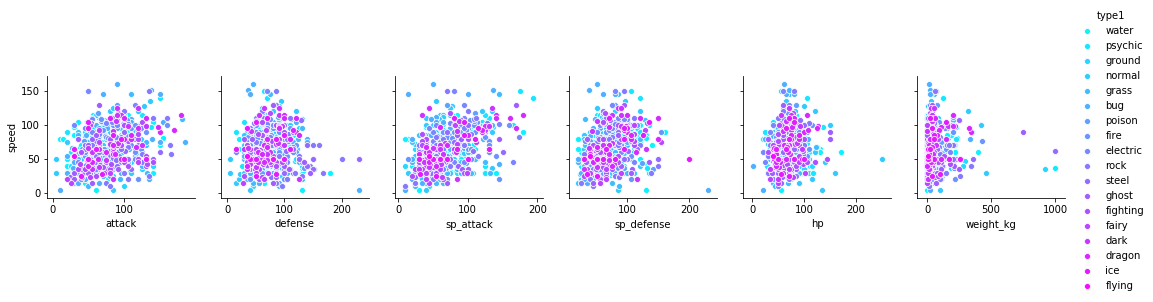

In [40]:
sns.pairplot(train,
        x_vars=["attack", 'defense', 'sp_attack', 'sp_defense', 'hp', 'weight_kg'],
        y_vars=['speed'], palette='cool',hue='type1', height=2.5);

## Regressão
Percebendo que assim não conseguiríamos identificar nenhuma relação, optamos por usar a biblioteca <b>statsmodel.api</b> para fazer a regressão pelo método dos Mínimos Quadrados. 

*Usamos apenas algumas variáveis, pois no contexto do dataframe e do jogo Pokémon sabemos que fazem referência a outros detalhes que não vão influenciar na velocidade do Pokémon, além de alguns conterem termos NaN, que atrapalham o uso deles como treino*

In [41]:
X = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation', 'experience_growth']]

Y = train[['speed']]

In [42]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [43]:
results = regress(Y,X)
results.summary()

C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     33.28
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           2.51e-43
Time:                        10:08:07   Log-Likelihood:                -2761.0
No. Observations:                 600   AIC:                             5540.
Df Residuals:                     591   BIC:                             5580.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                48.8623      7.439      6.568      0.000      34.252      63.473
attack                0.3285      0.040      8.269      0.000       0.250       0.406
defense              -0.2974      0.043     -6.929      0.000      -0.382      -0.213
sp_attack             0.2679      0.038      7.025      0.000       0.193       0.343
sp_defense            0.1236      0.048      2.572      0.010       0.029       0.218
hp                   -0.1286      0.049     -2.636      0.009      -0.224      -0.033
is_legendary         17.2964      4.220      4.099      0.000       9.008      25.584
generation           -1.3259      0.514     -2.581      0.010      -2.335      -0.317
experience_growth -2.481e-06   6.39e-06     -0.388      0.698    -1.5e-05    1.01e-05
==============================================================================
Omnibus:                       12.918   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.234
Skew:                           0.333   Prob(JB):                      0.00134
Kurtosis:                       3.292   Cond. No.                     8.31e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Analisando os resultados acima, percebemos que TODOS (com excessão de "experience_growth") são importantes para definir nossa variável *Target*, ou seja, a velocidade ("speed"). Apesar disso, nosso P é bem pequeno, o que não é um bom sinal, e portanto precisaremos de mais regressões se quisermos atingir a normalidade e poder prever fielmente nosso *Target*.

## Análise Rápida da previsão "como está"
Apenas para visualizarmos, abaixo segue o plot do predict (ou seja, a previsão que a biblioteca $sm$ faz) relacionado com os valores reais do nosso dataframe *teste*.

In [44]:
X_test = test[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation', 'experience_growth']]

Y_test = test[['speed']]

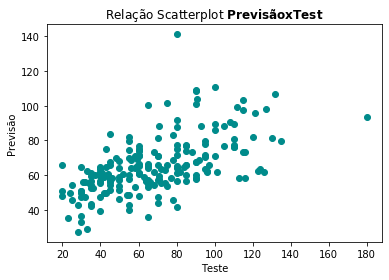

In [45]:
X_cp = sm.add_constant(X_test)
Y_predTest = results.predict(X_cp)

plt.title(r'Relação Scatterplot $\bf{Previsão x Test}$')
plt.xlabel('Teste')
plt.ylabel('Previsão')
plt.scatter(Y_test, Y_predTest, color='darkcyan');

## Aprofundamento na Análise Exploratória
Para aprimorarmos nossa previsão da velocidade dos Pokémons, precisamos também considerar variáveis <b>qualitativas</b>. Porém, a biblioteca $sm$ lida apenas com variáveis <b>quantitativas</b>. Como podemos então transformar essas variáveis para podermos analisar melhor nosso dataframe? A resposta é: com $Dummies$. Dummies é um comando da biblioteca $pandas$ que transforma as strings de uma classificação qualitativa em colunas de um dataframe assumindo valores de 0 ou 1, que equivalem a False e True, respectivamente. Assim, podemos usar essas novas colunas para uma análise exploratória mais aprofundada.

In [46]:
X_Types = train.iloc[:,43:]
X_Types 

,T1_bug,T2_bug,T1_dark,T2_dark,T1_dragon,T2_dragon,T1_electric,T2_electric,T1_fairy,T2_fairy,...,T1_poison,T2_poison,T1_psychic,T2_psychic,T1_rock,T2_rock,T1_steel,T2_steel,T1_water,T2_water
787,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
785,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
767,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
72,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
results = regress(Y,X_Types)
results.summary()

C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is dep

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     3.454
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           4.35e-10
Time:                        10:08:08   Log-Likelihood:                -2814.3
No. Observations:                 600   AIC:                             5701.
Df Residuals:                     564   BIC:                             5859.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          58.5303      2.273     25.747      0.000      54.065      62.995
T1_bug          1.9482      4.097      0.475      0.635      -6.100       9.996
T2_bug         -9.0907     12.500     -0.727      0.467     -33.643      15.462
T1_dark         9.8743      5.811      1.699      0.090      -1.539      21.288
T2_dark        15.6246      7.820      1.998      0.046       0.266      30.984
T1_dragon      13.8187      6.431      2.149      0.032       1.188      26.450
T2_dragon       2.5762      8.627      0.299      0.765     -14.369      19.521
T1_electric    17.8541      5.260      3.394      0.001       7.522      28.187
T2_electric    13.9112     10.581      1.315      0.189      -6.873      34.695
T1_fairy       -6.6731      7.238     -0.922      0.357     -20.890       7.544
T2_fairy       -3.1596      5.952     -0.531      0.596     -14.851       8.532
T1_fighting     1.7094      6.010      0.284      0.776     -10.095      13.514
T2_fighting    19.9413      6.951      2.869      0.004       6.289      33.594
T1_fire        10.5837      4.538      2.332      0.020       1.670      19.497
T2_fire        15.4692      9.544      1.621      0.106      -3.277      34.216
T1_flying      -6.1065     26.957     -0.227      0.821     -59.054      46.841
T2_flying      20.2241      3.594      5.627      0.000      13.164      27.284
T1_ghost       -6.7757      6.588     -1.028      0.304     -19.716       6.165
T2_ghost       -4.1213      8.958     -0.460      0.646     -21.716      13.473
T1_grass       -5.9841      3.987     -1.501      0.134     -13.815       1.847
T2_grass      -12.1343      7.970     -1.523      0.128     -27.788       3.519
T1_ground      -5.8860      6.196     -0.950      0.343     -18.055       6.283
T2_ground      -8.3253      6.504     -1.280      0.201     -21.101       4.451
T1_ice          5.5999      7.242      0.773      0.440      -8.625      19.824
T2_ice          7.9913      7.863      1.016      0.310      -7.454      23.436
T1_normal       5.1866      3.520      1.473      0.141      -1.728      12.101
T2_normal      34.7509     19.538      1.779      0.076      -3.625      73.126
T1_poison       1.1637      5.616      0.207      0.836      -9.867      12.194
T2_poison      10.4420      5.787      1.804      0.072      -0.925      21.809
T1_psychic     15.9880      4.711      3.394      0.001       6.734      25.242
T2_psychic      8.3763      6.170      1.358      0.175      -3.743      20.495
T1_rock         0.1228      4.910      0.025      0.980      -9.521       9.767
T2_rock       -27.1746      9.193     -2.956      0.003     -45.232      -9.117
T1_steel        3.4100      7.337      0.465      0.642     -11.001      17.821
T2_steel       -4.6000      6.985     -0.659      0.510     -18.319       9.119
T1_water        2.6963      3.416      0.78

## Analisando a regressão da variável Tipo 1
Analisando essa primeira tabela da regressão, percebe-se uma forte relação dos tipos electric, fire, flying e psychic com a velocidade. Seguimos aprofundando na análise. 

In [48]:
# X_Type1 = dummies_type1.loc[:, ['electric', 'fire', 'flying', 'psychic']]
# results = regress(Y,X_Type1)
# results.summary()

## Analisando a regressão da variável Tipo 2
Analisando essa tabela da regressão, percebe-se uma forte relação dos tipos 2 fighting, flying, rock e water com a velocidade. Seguimos aprofundando na análise. 

In [49]:
# X_Type2 = dummies_type2.loc[:, ['fighting', 'flying', 'rock', 'water']]
# results = regress(Y,X_Type2)
# results.summary()

## Analisando a regressão da variável dos tipos
Analisando a tabela de regressão, percebe-se uma forte relação dos tipos escolhidos com a velocidade. Essa escolha foi feita a base de um alfa de 5%.

In [50]:
X_Types_Imp = X_Types.loc[:,['T2_dark','T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 
                             'T1_psychic', 'T2_psychic', 'T2_rock']]

In [51]:
results = regress(Y,X_Types_Imp)
results.summary()

C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is dep

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     9.832
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           7.08e-13
Time:                        10:08:08   Log-Likelihood:                -2835.1
No. Observations:                 600   AIC:                             5688.
Df Residuals:                     591   BIC:                             5728.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          60.6235      1.360     44.566      0.000      57.952      63.295
T2_dark        14.3765      7.745      1.856      0.064      -0.834      29.587
T1_electric    16.7523      5.262      3.184      0.002       6.418      27.086
T2_fighting    22.6118      6.805      3.323      0.001       9.248      35.976
T1_flying      -5.6235     27.523     -0.204      0.838     -59.679      48.432
T2_flying      21.3667      3.405      6.276      0.000      14.680      28.053
T1_psychic     12.6966      4.636      2.738      0.006       3.591      21.802
T2_psychic     10.0583      6.017      1.672      0.095      -1.758      21.875
T2_rock       -28.2235      8.799     -3.208      0.001     -45.504     -10.943
==============================================================================
Omnibus:                       20.794   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.319
Skew:                           0.464   Prob(JB):                     1.42e-05
Kurtosis:                       2.823   Cond. No.                         24.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regressão Aprofundada
Agora que temos alguma noção de quais variáveis importam para nós e quais não, podemos fazer uma regressão apenas com essas variáveis, e ver se conseguimos usar esse modelo para prever com mais precisão a base de *teste*.

In [52]:
# # Type1 importantes: electric, fire, flying, psychic
# # Type2 importantes: fighting, flying, rock, water

# Type1Imp = ['electric', 'fire', 'flying', 'psychic']
# Type2Imp = ['fighting', 'flying', 'rock', 'water']

# # Usaremos essas listas para criar colunas personalizadas no dataframe Train para poder diferenciar type1 de type2
# # Assim, já podemos aproveitar e usar os dataframse de Dummies para isso

# for i in range(4):
#     train.loc[:,'T1_'+Type1Imp[i]] = dummies_type1[Type1Imp[i]]
#     train.loc[:,'T2_'+Type2Imp[i]] = dummies_type2[Type2Imp[i]]
    
# train

In [53]:
X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation','T2_dark',
                'T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 'T1_psychic', 'T2_psychic', 'T2_rock']]

In [54]:
results = regress(Y,X_comp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     21.93
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           1.86e-47
Time:                        10:08:08   Log-Likelihood:                -2738.6
No. Observations:                 600   AIC:                             5509.
Df Residuals:                     584   BIC:                             5579.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           41.9916      4.129     10.169      0.000      33.882      50.102
attack           0.3118      0.040      7.862      0.000       0.234       0.390
defense         -0.2416      0.044     -5.458      0.000      -0.329      -0.155
sp_attack        0.2433      0.038      6.359      0.000       0.168       0.318
sp_defense       0.1209      0.047      2.582      0.010       0.029       0.213
hp              -0.1281      0.047     -2.713      0.007      -0.221      -0.035
is_legendary    14.3921      4.012      3.587      0.000       6.513      22.271
generation      -1.2480      0.503     -2.483      0.013      -2.235      -0.261
T2_dark          6.7088      6.704      1.001      0.317      -6.458      19.875
T1_electric      8.6727      4.618      1.878      0.061      -0.397      17.742
T2_fighting     11.0479      5.984      1.846      0.065      -0.705      22.801
T1_flying        8.9373     23.669      0.378      0.706     -37.549      55.424
T2_flying       18.0125      2.941      6.125      0.000      12.237      23.788
T1_psychic       3.8003      4.213      0.902      0.367      -4.474      12.075
T2_psychic       4.9870      5.210      0.957      0.339      -5.245      15.219
T2_rock        -12.8292      8.008     -1.602      0.110     -28.557       2.898
==============================================================================
Omnibus:                       14.701   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.089
Skew:                           0.373   Prob(JB):                     0.000529
Kurtosis:                       3.216   Cond. No.                     4.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
# T2_dark, T2_fighting, T1_flying, T1_psychic, T2_psychic e T2_rock não são importantes, e podemos descartá-los

X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation',
                'T1_electric', 'T2_flying']]

results = regress(Y,X_comp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     35.46
Date:                Tue, 24 Nov 2020   Prob (F-statistic):           4.09e-50
Time:                        10:08:08   Log-Likelihood:                -2742.9
No. Observations:                 600   AIC:                             5506.
Df Residuals:                     590   BIC:                             5550.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           42.4821      4.104     10.351      0.000      34.422      50.543
attack           0.3214      0.039      8.347      0.000       0.246       0.397
defense         -0.2691      0.042     -6.415      0.000      -0.352      -0.187
sp_attack        0.2552      0.037      6.826      0.000       0.182       0.329
sp_defense       0.1276      0.047      2.741      0.006       0.036       0.219
hp              -0.1301      0.047     -2.758      0.006      -0.223      -0.037
is_legendary    15.7218      3.964      3.966      0.000       7.937      23.507
generation      -1.1674      0.500     -2.336      0.020      -2.149      -0.186
T1_electric      7.4411      4.581      1.624      0.105      -1.556      16.438
T2_flying       17.2428      2.922      5.901      0.000      11.504      22.982
==============================================================================
Omnibus:                       13.174   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.416
Skew:                           0.356   Prob(JB):                      0.00122
Kurtosis:                       3.176   Cond. No.                         857.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Ajustando o Dataframe *Test*
Sabendo o que estamos indo atrás agora, para podermos usar o comando *.predict*, precisamos preparar o df *test* para ter as mesmas colunas relativas a ele que usaremos no df *train*. As próximas células fazem exatamente isso.

In [56]:
# Como a regressão não melhorou nosso R-squared, utilizaremos o anterior para fazer um teste do data frame
X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation','T2_dark',
                'T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 'T1_psychic', 'T2_psychic', 'T2_rock']]

X_TestComp = test[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation','T2_dark',
                'T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 'T1_psychic', 'T2_psychic', 'T2_rock']]

In [57]:
results = regress(Y,X_comp)

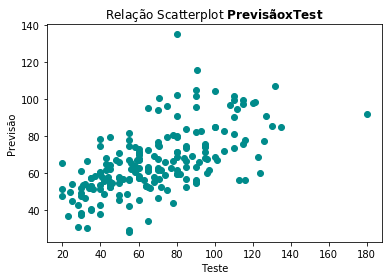

In [67]:
X_cnt = sm.add_constant(X_TestComp)
Y_predTest = results.predict(X_cnt)

plt.title(r'Relação Scatterplot $\bf{Previsão x Test}$')
plt.xlabel('Teste')
plt.ylabel('Previsão')
plt.scatter(Y_test, Y_predTest, color='darkcyan');

## EXPLICAR REGRESSÃO LINEAR

In [59]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)

X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation','T2_dark',
                'T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 'T1_psychic', 'T2_psychic', 'T2_rock']]

regressor.fit(X_comp, Y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [60]:
regressor.score(X_comp, Y)

0.9987194770787039

In [61]:
#arvore tende a ir bem em cima do treinamento dela

In [62]:
X_comp

,attack,defense,sp_attack,sp_defense,hp,is_legendary,generation,T2_dark,T1_electric,T2_fighting,T1_flying,T2_flying,T1_psychic,T2_psychic,T2_rock
787,75,115,95,130,70,1,7,0,0,0,0,0,0,0,0
785,85,75,130,115,70,1,7,0,0,0,0,0,1,0,0
449,112,118,68,72,108,0,4,0,0,0,0,0,0,0,0
189,70,55,40,55,55,0,2,0,0,0,0,0,0,0,0
494,45,55,45,55,45,0,5,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,131,95,131,98,126,1,6,0,0,0,0,0,0,0,0
767,125,140,60,90,75,0,7,0,0,0,0,0,0,0,0
72,70,65,80,120,80,0,1,0,0,0,0,0,0,0,0
235,35,35,35,35,35,0,2,0,0,0,0,0,0,0,0


In [63]:
X_TesteComp = test.loc[:, X_comp.columns]

In [64]:
regressor.score(X_TesteComp, Y_test)

-0.1627202817618434

In [ ]:
# overfit na base de treinamento
# arvore nao generalizou bem
# desempenho ruim 
# o generalizacao da arvore vai "contra" a base de teste
# maximizar o valor de R^2, mas comentar as probabilidades, aproximação da normal
#modelos que escolhemos não são ideais para prever essa variável

## EXPLICAR ÁRVORE DE REGRESSÃO

## CONCLUIR O RELTÓRIO